## **Vector Simulation**
---

>## 2-Link Manipulator

- **Scenario**
    - Initial conditions (manipulator arm hanging down): `x0 = [-3pi/8; 0.0; 0; 0]` (q1; q2; dq1; dq2)
    - First order ODE, no external force
- **Formulas** 
$$
\begin{bmatrix}
\dot{x}_1 \\
\dot{x}_2
\end{bmatrix}
=
\begin{bmatrix}
x_2 \\
- D^{-1}(x_1) \cdot \left[ C(x_1, x_2) \cdot x_2 + G(x_1) \right] + D^{-1}(x_1) \cdot B\tau
\end{bmatrix}
$$
- **Key Takeaways**
    - Use the library function to get D, G, C ...
    - `dx1 = dq`;  `dx2 = (model.D) \ (-model.C*dq-model.G)`

Packages used:
<span style="color:yellow; background-color:green">DifferentialEquations, Plots, LinearAlgebra, LaTeXStrings</span>


In [15]:
using DifferentialEquations, Plots, LinearAlgebra, LaTeXStrings
include("src/manipulator_library.jl")

cleanUp (generic function with 2 methods)

In [10]:
gr()

# 2-Link Manipulator Model
function modelParameters()
    g = 9.81
    L1 = 1.0
    L2 = 0.5
    m1 = 1.0
    m2 = 3.0
    return g, L1, L2, m1, m2
end

# define the ODE dx/dt = f(x,t)
#
# the parameters are passed via modelParameters() in the
# function dyn_mod_2LinkManipulator(q, dq)
#
function f(x,~,t)
    n = floor(Int, length(x) / 2) # In Julia n/2 is a Float64
    q = x[1:n]
    dq = x[n+1:end]
    model = dyn_mod_2LinkManipulator(q, dq)
    dx1 = dq
    dx2 = (model.D) \ (-model.C*dq-model.G) # note the use of backslash
    dx=[dx1;dx2]
    return dx
end

f (generic function with 1 method)

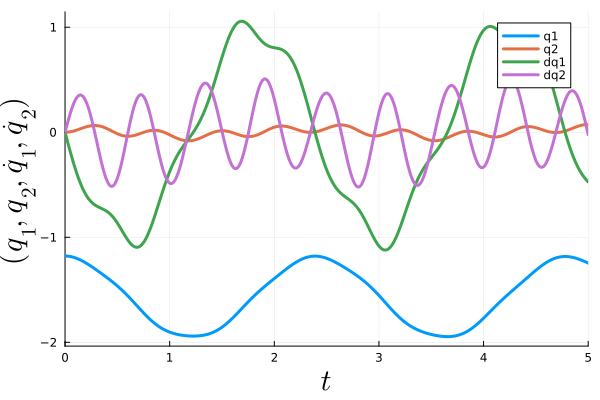

In [11]:
# Set the initial condition as a vector
x0= [-3pi/8; 0.0; 0; 0]

# Set the time interval
T = (0.0, 5) 

# Setup the ODE problem with out-of-place function
# params removed 
problem = ODEProblem{false}(f, x0, T)

# solve the ODE problem using the Runge Kutta Tsitouras 5/4 Integrator
sol = solve(problem, Tsit5());

# plot the solution
p1 = plot(sol, lw=3, guidefont=20, xlabel=L"t", ylabel=L"(q_1, q_2, \dot{q}_1, \dot{q}_2)", 
    label=["q1" "q2" "dq1" "dq2"], legend=:topright)

#png(p1, "2LinkManipulatorSimulationChap09")
display(p1)

>## 2-Link Manipulator with spring

- **Scenario**
    - 2-link manipulator with springs added to both revolute joints
    - Find the equilibrium point $q_e = [q_1^*; q_2^*]$
$$
x_e = \left\{ 
\begin{bmatrix}
q_e \\
0
\end{bmatrix}
\in \mathbb{R}^{2n} \ \middle| \ G(q_e) = 0_{n \times 1} 
\right\}
$$
- **Key Takeaways**
    - Use the library function to get G, JacG
    - Apply Newton-Raphson routine to find G($q_1^*$, $q_2^*$) = [0; 0]
$$
J(x_k) \, \Delta x = -G(x_k)
$$

In [ ]:
# Starting point
x0 = [pi/2, pi/4]

Model = dyn_mod_2LinkManipulatorWithSprings(x0, 0*x0)
G = Model.G
JacG = Model.JacG
k = 0
aTol = 1e-5
s = 0.1
xk = x0

while (k<1e5)&&(norm(G)>aTol)
    k = k+1
    Delta_x = -JacG\G    
    xk = xk + s*Delta_x
    Model = dyn_mod_2LinkManipulatorWithSprings(xk, 0*xk)
    G = Model.G
    JacG = Model.JacG
end
Model = dyn_mod_2LinkManipulatorWithSprings(xk, 0*xk)
G = Model.G
JacG = Model.JacG

display(G)
# Equilibrium point xk 
[xk x0] 

2-element Vector{Float64}:
 -2.959527982682175e-6
  9.381671145725079e-6

2×2 Matrix{Float64}:
 -1.03536   1.5708
 -0.201158  0.785398

>## 3-Link Manipulator linear model

- **Scenario**
    - Linearize around the equilibrium point (Find Jacobian)
    - Equilibrium point given (`qe = [-pi/2, 0, 0] || qe = [-pi/2, 0, 0]`)
$$
f(x) = f(x_e) + \left. \frac{\partial f(x)}{\partial x} \right|_{x = x_e} (x - x_e)
= \frac{\partial f(x_e)}{\partial x} \cdot (x - x_e)\\
{}\\
\dot{\delta x} = \frac{\partial f(x_e)}{\partial x} \cdot \delta x
$$
- **Robot Equation Stuff**
$$
D(q) \cdot \ddot{q} + C(q, \dot{q}) \cdot \dot{q} + G(q) = 0 \\
{}\\
\text{Linearized : } D(q_e) \cdot \delta\ddot{q} + \frac{\partial G(q_e)}{\partial q} \cdot \delta q = 0_{n \times 1}\\
{}\\
=> \begin{bmatrix}
\delta \dot{x}_1 \\
\delta \dot{x}_2
\end{bmatrix}
=
\begin{bmatrix}
0_n & I_n \\
A_{21} & 0_n
\end{bmatrix}
\begin{bmatrix}
\delta x_1 \\
\delta x_2
\end{bmatrix}\\
{}\\
\text{where} \quad A_{21} = -D(q_e) \backslash \frac{\partial G(q_e)}{\partial q}
$$

In [17]:
function modelParameters()
    g = 9.81 # m/s^2
    L1 = 1 # m
    L2 = 0.7
    L3 = 0.5
    m1 = 15 # kg
    m2 = 10
    m3 = 5    
    return g, L1, L2, L3, m1, m2, m3
end

# Set equilibirum Point
if true
    qe = [-pi/2, 0, 0]
else
    qe = [pi/2, 0, 0]
end

F = dyn_mod_3LinkManipulator(qe, 0*qe)
D = F.D; display(D)
JacG = F.JacG; display(JacG)

# build the linearized model about the give equilibrium point
A21 = -D\JacG; A21 = cleanUp(A21); display(A21)
n, ~ = size(A21)
A = [zeros(n,n) I(n); A21 zeros(n,n)]

# Eigenvalues
E=eigen(A)
evals = cleanUp(E.values); display(evals)

3×3 Matrix{Float64}:
 68.1  25.1  5.5
 25.1  12.1  3.0
  5.5   3.0  1.25

3×3 Matrix{Float64}:
 421.83   127.53   24.525
 127.53   127.53   24.525
  24.525   24.525  24.525

3×3 Matrix{Float64}:
 -9.81    9.81      0.0
  9.81  -37.8386    7.00714
  0.0    28.0286  -36.4371

6-element Vector{ComplexF64}:
 0.0 - 7.23885032225449im
 0.0 + 7.23885032225449im
 0.0 - 2.452784229773624im
 0.0 + 2.452784229773624im
 0.0 - 5.066419822703628im
 0.0 + 5.066419822703628im